<a href="https://colab.research.google.com/github/hab5510/finrl_project/blob/main/with_sentiment/FinRL_with_SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading with Sentiment Analysis, Multiple Stock Trading




# Content

1. **Task Description**
2. **Install & Import Packages**
3. **Download and Preprocess Data**
4. **Sentiment Analysis**
   - Financial News Dataset (FNSPID)
   - FinBERT Classification
   - Feature Engineering (Raw Sentiment)
5. **Build Trading Environment**
   - Environment Setup
   - Data Split
6. **Training the Agents**
   - A2C
   - PPO
   - TD3
7. **Out-of-sample Trading**
8. **Evaluation and Results**
   - Portfolio Values
   - Cumulative Return and Sharpe Ratio

<a id='0'></a>
# Part 1. Task Description


This notebook investigates whether adding raw sentiment signals from financial news can improve the performance of reinforcement learning agents in stock trading.

We use FinBERT to analyze financial headlines and generate daily sentiment scores per stock.  
These scores are then integrated into the FinRL trading environment and fed to three DRL agents (A2C, PPO, TD3).

The agents are trained on historical data and tested on unseen data from 2023.  
We compare their performance using final portfolio value, cumulative return, and Sharpe ratio, against a passive DJI benchmark.



<a id='1'></a>
# Part 2. Install & Import Packages

<a id='1.1'></a>
### Install packages


In [ ]:
!pip install numpy==1.26.4 --force-reinstall


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 91.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
# Upgrade pip to avoid version resolution issues
!pip install --upgrade pip

# Install compatible PyTorch, torchvision, torchaudio (CPU for Colab stability)
!pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --extra-index-url https://download.pytorch.org/whl/cpu


!pip install -q stable-baselines3==2.2.1 sb3-contrib==2.2.1 gymnasium==1.0.0
!pip install -q git+https://github.com/AI4Finance-Foundation/FinRL.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.8/186.8 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.21.0+cu124
    Uninstalling torchvision-0.21.0+cu124:
      Successfully uninstalled torchvision-0.21.0+cu124
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.6.0+cu124
    Unins

<a id='1.3'></a>
###Import Packages

In [ ]:
!pip install pandas_market_calendars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [pandas_market_calendars]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

/usr/local/lib/python3.11/dist-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)
/usr/local/lib/python3.11/dist-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


<a id='1.4'></a>
### Create Folders

In [ ]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download and Preprocess Data

The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).

We are using 10 of the top 10 Tickers in the market : AAPL, MSFT, AMZN, GOOGL, META,
                 NVDA, JPM, TSLA, BA, DIS



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [ ]:
TRAIN_START_DATE = '2020-01-01'
TRAIN_END_DATE = '2023-01-01'
TRADE_START_DATE = '2023-01-01'
TRADE_END_DATE = '2023-12-31'


In [ ]:
top10_tickers = ['AAPL','MSFT','AMZN','GOOGL','META',
                 'NVDA','JPM','TSLA','BA','DIS']

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = top10_tickers).fetch_data()

YF deprecation warning: set proxy via new config function: yf.set_config(proxy=proxy)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (10060, 8)


In [ ]:
df.shape

(10060, 8)

In [ ]:
df.sort_values(['date','tic'],ignore_index=True).head()

Price,date,close,high,low,open,volume,tic,day
0,2020-01-02,72.620842,72.681289,71.373218,71.627092,135480400,AAPL,3
1,2020-01-02,94.900497,94.900497,93.207497,93.750000,80580000,AMZN,3
2,2020-01-02,331.348572,331.378393,325.761816,326.606765,4544400,BA,3
3,2020-01-02,145.769913,145.769913,142.720753,142.907625,9502100,DIS,3
4,2020-01-02,68.026016,68.026016,66.923134,67.018562,27278000,GOOGL,3


### Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)


Successfully added technical indicators


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (1005, 8)
Successfully added vix
Successfully added turbulence index


# Part 4. Sentiment Analysis



### Financial News Dataset: FNSPID

We use the FNSPID dataset, which contains 15.7M financial news headlines labeled with stock tickers and publication time.

In this notebook, headlines are processed using FinBERT to compute daily sentiment scores for each stock.

It is available at https://huggingface.co/datasets/Zihan1004/FNSPID  . It was directly downloaded as csv and uploaded below.


In [ ]:
import pandas as pd

# Quickly inspect only the first line (header) – no memory problems
with open("fnspid_news.csv", "r") as f:
    header = f.readline().strip().split(",")
print("CSV columns:", header[:20])

FileNotFoundError: [Errno 2] No such file or directory: 'fnspid_news.csv'

In [ ]:
import pandas as pd

FILE       = "fnspid_news.csv"
COLS       = ["Date", "Article_title", "Stock_symbol"]
TOP10      = set(['AAPL','MSFT','AMZN','GOOGL','META',
                  'NVDA','JPM','TSLA','BA','DIS'])
DATE_MIN   = "2020-01-01"
DATE_MAX   = "2023-12-31"

chunksize  = 250_000

keep_rows  = []             # list of filtered chunks

for i,chunk in enumerate(pd.read_csv(FILE,
                                     usecols=COLS,
                                     chunksize=chunksize,
                                     dtype={"Stock_symbol":"category"},
                                     engine="c",
                                     low_memory=True)):
    # fast date filter
    mask_date   = (chunk["Date"] >= DATE_MIN) & (chunk["Date"] <= DATE_MAX)
    mask_ticker = chunk["Stock_symbol"].isin(TOP10)
    sub         = chunk.loc[mask_date & mask_ticker, COLS]
    if not sub.empty:
        keep_rows.append(sub)
    print(f"processed chunk {i+1}, kept {len(sub)} rows")

# concatenate all kept pieces
df_news = pd.concat(keep_rows, ignore_index=True)

# rename & convert date
df_news = df_news.rename(columns={
    "Date": "date",
    "Article_title": "headline",
    "Stock_symbol": "ticker"
})
df_news["date"] = pd.to_datetime(df_news["date"])

print("Final shape:", df_news.shape)
df_news.head()


###FinBERT Classification

Classifies each headline as positive, neutral, or negative using a finance-specific BERT model.

In [ ]:
import torch, time
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd

# Load FinBERT
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model     = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
model.eval()

def classify_headlines(texts, batch_size=8, log_every=500):
    results, t0 = [], time.time()
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        encodings = tokenizer(batch, padding=True, truncation=True,
                              max_length=48, return_tensors="pt")
        with torch.no_grad():
            logits = model(**encodings).logits
        preds = torch.argmax(logits, dim=1).tolist()
        results.extend({0:-1, 1:0, 2:1}[p] for p in preds)
        if i % log_every == 0 and i > 0:
            print(f"{i}/{len(texts)} processed ({time.time()-t0:.1f}s)")
    return results


In [ ]:
df_news.head()

In [ ]:
df_news["score"] = classify_headlines(df_news["headline"].tolist())


In [ ]:
df_news.to_csv("scored_news.csv", index=False)




###Feature Engineering : Raw Sentiment

Computes daily average sentiment scores per stock using FinBERT output.

In [ ]:
df_news = pd.read_csv("scored_news.csv")


In [ ]:
daily_sent = (df_news[["date","ticker","score"]]
              .groupby(["date","ticker"]).mean().reset_index()
              .rename(columns={"score":"sentiment_score"}))
daily_sent.to_csv("daily_sentiment.csv", index=False)


In [ ]:
daily_sent = pd.read_csv("daily_sentiment.csv")          # loads in <1 s
# Ensure date strings match format
processed["date"]  = pd.to_datetime(processed["date"]).dt.strftime("%Y-%m-%d")
daily_sent["date"] = pd.to_datetime(daily_sent["date"]).dt.strftime("%Y-%m-%d")

processed = processed.merge(
    daily_sent,
    left_on=["date", "tic"],
    right_on=["date", "ticker"],
    how="left"
)

# Fill NaN sentiment with 0
processed["sentiment_score"] = processed["sentiment_score"].fillna(0)

# Drop the extra 'ticker' column if it exists
if "ticker" in processed.columns:
    processed = processed.drop(columns=["ticker"])


In [ ]:
# 3 ── build processed_full so the RL environment sees every (date, ticker)
list_ticker = processed["tic"].unique().tolist()
list_date   = list(pd.date_range(processed['date'].min(),
                                 processed['date'].max()).astype(str))
combination = list(itertools.product(list_date, list_ticker))

processed_full = (
    pd.DataFrame(combination, columns=["date", "tic"])
      .merge(processed, on=["date", "tic"], how="left")
)
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date', 'tic'])
processed_full = processed_full.fillna(0)


In [ ]:
processed_full.to_csv("processed_full.csv", index=False)

<a id='4'></a>
# Part 5. Build Trading Environment
#### Environment Setup

We use FinRL's `StockTradingEnv`, modified to include:
- Price-based technical indicators
- Sentiment features (raw, optimized, volatility)

#### Data Split
- **Training**: Jan 2020 – Dec 2022
- **Testing**: Jan 2023 – Dec 2023


In [ ]:
INDICATORS = [
    'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30',
    'close_30_sma', 'close_60_sma', 'sentiment_score', 'vix', 'turbulence'
]

In [ ]:
# Keep only the valid columns

VALID_COLUMNS = ['date', 'tic', 'open', 'high', 'low', 'close', 'volume','day'] + INDICATORS
processed_full = pd.read_csv("processed_full.csv")
processed_full = processed_full[VALID_COLUMNS]
processed_full.dropna(inplace=True)

In [ ]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(20)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,sentiment_score,vix,turbulence
0,2020-01-02,AAPL,71.627092,72.681289,71.373218,72.620842,135480400.0,3.0,0.000000,73.266313,71.269332,0.0,-66.666667,100.0,72.620842,72.620842,0.000000,12.47,0.0
1,2020-01-02,AMZN,93.750000,94.900497,93.207497,94.900497,80580000.0,3.0,0.000000,73.266313,71.269332,0.0,-66.666667,100.0,94.900497,94.900497,0.000000,12.47,0.0
2,2020-01-02,BA,326.606765,331.378393,325.761816,331.348572,4544400.0,3.0,0.000000,73.266313,71.269332,0.0,-66.666667,100.0,331.348572,331.348572,-1.000000,12.47,0.0
3,2020-01-02,DIS,143.517032,146.391525,143.329363,146.391525,9502100.0,3.0,0.000000,73.266313,71.269332,0.0,-66.666667,100.0,146.391525,146.391525,-0.800000,12.47,0.0
4,2020-01-02,GOOGL,67.018569,68.026024,66.923141,68.026024,27278000.0,3.0,0.000000,73.266313,71.269332,0.0,-66.666667,100.0,68.026024,68.026024,-0.666667,12.47,0.0
5,2020-01-02,JPM,119.621142,120.742147,119.167612,120.733582,10803700.0,3.0,0.000000,73.266313,71.269332,0.0,-66.666667,100.0,120.733582,120.733582,-0.250000,12.47,0.0
6,2020-01-02,META,205.621925,208.645331,205.144548,208.635391,12077100.0,3.0,0.000000,73.266313,71.269332,0.0,-66.666667,100.0,208.635391,208.635391,0.000000,12.47,0.0
7,2020-01-02,MSFT,151.289093,153.147093,150.860326,153.042282,22622100.0,3.0,0.000000,73.266313,71.269332,0.0,-66.666667,100.0,153.042282,153.042282,0.000000,12.47,0.0
8,2020-01-02,NVDA,5.942872,5.971746,5.892343,5.971746,237536000.0,3.0,0.000000,73.266313,71.269332,0.0,-66.666667,100.0,5.971746,5.971746,-1.000000,12.47,0.0
9,2020-01-02,TSLA,28.299999,28.713333,28.114000,28.684000,142981500.0,3.0,0.000000,73.266313,71.269332,0.0,-66.666667,100.0,28.684000,28.684000,-0.500000,12.47,0.0


In [ ]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

7617
2490


In [ ]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,sentiment_score,vix,turbulence
755,2022-12-30,JPM,124.543618,125.969014,124.196653,125.753334,9292500.0,4.0,0.423462,126.849705,120.917203,57.143990,20.441574,11.345593,124.882475,119.589299,0.000000,21.67,0.766227
755,2022-12-30,META,117.515305,119.762968,117.097591,119.683403,19583800.0,4.0,0.952231,122.984848,111.411239,49.419032,78.427199,9.186714,115.435049,115.697443,0.000000,21.67,0.766227
755,2022-12-30,MSFT,233.466251,235.181401,231.947115,235.044189,21938500.0,4.0,-1.366760,253.270814,227.343642,48.258163,-86.504819,5.313326,240.472864,234.587168,-0.333333,21.67,0.766227
755,2022-12-30,NVDA,14.321271,14.616009,14.220361,14.601023,310490000.0,4.0,-0.309793,18.503090,13.800796,47.045448,-141.558853,13.239276,16.120591,14.735053,0.125000,21.67,0.766227
755,2022-12-30,TSLA,119.949997,124.480003,119.750000,123.180000,157777300.0,4.0,-19.258998,202.513339,99.254662,32.790586,-121.998583,47.953532,161.267667,186.598834,-0.210526,21.67,0.766227


In [ ]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,sentiment_score,vix,turbulence
0,2023-01-03,AAPL,128.613978,129.226044,122.582112,123.470604,112117500.0,1.0,-4.648600,147.860275,121.091834,39.011473,-130.963621,35.956352,138.293931,140.567286,-0.448276,22.9,29.954638
0,2023-01-03,AMZN,85.459999,86.959999,84.209999,85.820000,76706000.0,1.0,-3.075118,93.357149,80.929850,41.195599,-71.360174,10.198927,89.424999,97.181000,0.000000,22.9,29.954638
0,2023-01-03,BA,192.949997,197.179993,192.399994,195.389999,8624600.0,1.0,5.326285,196.702727,176.154272,62.905353,141.206999,44.456630,182.859667,166.269167,0.000000,22.9,29.954638
0,2023-01-03,DIS,87.894196,88.872113,86.758227,87.884315,14997100.0,1.0,-2.406148,95.859728,81.780766,44.489021,-57.420591,3.756592,91.139430,94.093272,-0.333333,22.9,29.954638
0,2023-01-03,GOOGL,89.055906,90.507209,87.992285,88.588715,28131200.0,1.0,-2.129973,98.089498,83.452728,43.976971,-67.730627,2.932357,92.974732,93.988818,0.000000,22.9,29.954638


In [ ]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 10, State Space: 131


In [ ]:

from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
import numpy as np

EXPECTED_STATE_DIM = state_space

def force_fixed_state(obs):
    obs = np.asarray(obs, dtype=np.float32).flatten()
    if obs.shape[0] != EXPECTED_STATE_DIM:
        print(f"Auto-fixing bad obs shape {obs.shape[0]} → {EXPECTED_STATE_DIM}")
        if obs.shape[0] < EXPECTED_STATE_DIM:
            # Pad with zeros
            obs = np.pad(obs, (0, EXPECTED_STATE_DIM - obs.shape[0]), mode='constant')
        else:
            # Truncate
            obs = obs[:EXPECTED_STATE_DIM]
    return obs.reshape(1, -1)


class PatchedStockTradingEnv(StockTradingEnv):
    def reset(self, *, seed=None, options=None):
        obs, info = super().reset(seed=seed, options=options)
        obs = force_fixed_state(obs)
        return obs, info

    def step(self, action):
        obs, reward, terminated, truncated, info = super().step(action)
        obs = force_fixed_state(obs)
        return obs, reward, terminated, truncated, info








In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

from stable_baselines3.common.vec_env import DummyVecEnv

env_train = DummyVecEnv([lambda: PatchedStockTradingEnv(df=train, **env_kwargs)])






In [ ]:


obs = env_train.reset()
print("obs shape:", obs.shape, "dtype:", obs.dtype)

action = np.zeros(stock_dimension)
obs, reward, done, info = env_train.step(action)
print("step shape:", obs.shape, "dtype:", obs.dtype)


obs shape: (1, 131) dtype: float32
step shape: (1, 131) dtype: float32


/usr/local/lib/python3.11/dist-packages/finrl/meta/env_stock_trading/env_stocktrading.py:328: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  sell_index = argsort_actions[: np.where(actions < 0)[0].shape[0]]


In [ ]:
obs = env_train.reset()
print("Training reset shape:", obs.shape, obs.dtype)

obs, reward, done, info = env_train.step(np.zeros(stock_dimension))
print("Training step shape:", obs.shape, obs.dtype)



Training reset shape: (1, 131) float32
Training step shape: (1, 131) float32


<a id='5'></a>

# Part 6. Training the Agents (A2C, PPO, TD3)

Each model is trained independently on the same market + sentiment environment.
Training duration varies (TD3 longer than others).


### Agent 1: A2C


In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")


# set up logger
tmp_path = RESULTS_DIR + '/a2c'
new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [ ]:
print(repr(env_train.reset()))

array([[ 1.0000000e+06,  7.2620842e+01,  9.4900497e+01,  3.3134857e+02,
         1.4639153e+02,  6.8026024e+01,  1.2073358e+02,  2.0863539e+02,
         1.5304228e+02,  5.9717464e+00,  2.8684000e+01,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  7.3266312e+01,
         7.3266312e+01,  7.3266312e+01,  7.3266312e+01,  7.3266312e+01,
         7.3266312e+01,  7.3266312e+01,  7.3266312e+01,  7.3266312e+01,
         7.3266312e+01,  7.1269333e+01,  7.1269333e+01,  7.1269333e+01,
         7.1269333e+01,  7.1269333e+01,  7.1269333e+01,  7.1269333e+01,
         7.1269333e+01,  7.1269333e+01,  7.1269333e+01,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.00000

In [ ]:
trained_a2c  = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=50000)

Auto-fixing bad obs shape 155 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 191 → 131
Auto-fixing bad obs shape 179 → 131
Auto-fixing bad obs shape 359 → 131
Auto-fixing bad obs shape 419 → 131
--------------------------------------
| time/                 |            |
|    fps                | 281        |
|    iterations         | 100        |
|    time_elapsed       | 1          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -14.2      |
|    explained_variance | -0.121     |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -42.8      |
|    reward             | 1.173566   |
|    reward_max         | 3.400621   |
|    reward_mean        | 1.6911371  |
|    reward_min         | -2.0367193 |
|    std                | 1.01       |
|    value_loss         | 10.8       |
----------

### Agent 2: PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

  # set up logger
tmp_path = RESULTS_DIR + '/ppo'
new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [ ]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=50000)

Auto-fixing bad obs shape 155 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 191 → 131
Auto-fixing bad obs shape 179 → 131
Auto-fixing bad obs shape 359 → 131
Auto-fixing bad obs shape 419 → 131
Auto-fixing bad obs shape 155 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 191 → 131
Auto-fixing bad obs shape 179 → 131
Auto-fixing bad obs shape 359 → 131
Auto-fixing bad obs shape 419 → 131
Auto-fixing bad obs shape 155 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 143 → 131
Auto-fixing bad obs shape 191 → 131
Auto-fixing bad obs shape 179 → 131
Auto-fixing bad obs shape 359 → 131
Auto-fixing bad obs shape 419 → 131
-------------------------------------
| time/              |              |
|    fps             | 384          |
|    iterations      |

### Agent 3: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100,
              "buffer_size": 1000000,
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

  # set up logger
tmp_path = RESULTS_DIR + '/td3'
new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3


In [ ]:
trained_td3 = agent.train_model(model=model_td3,
                             tb_log_name='td3',
                             total_timesteps=50000)

Streaming output truncated to the last 5000 lines.
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollout_buffer'
Logging Error: 'rollo


# Part 7. Out-of-Sample Trading

This section simulates live trading by deploying each trained agent on **unseen test data from 2023**.

Each agent starts with **$1,000,000** and trades across 10 U.S. stocks.  
Daily portfolio values are recorded to evaluate performance later.



In [ ]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)

In [ ]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,sentiment_score,vix,turbulence
0,2023-01-03,AAPL,128.613978,129.226044,122.582112,123.470604,112117500.0,1.0,-4.648600,147.860275,121.091834,39.011473,-130.963621,35.956352,138.293931,140.567286,-0.448276,22.9,29.954638
0,2023-01-03,AMZN,85.459999,86.959999,84.209999,85.820000,76706000.0,1.0,-3.075118,93.357149,80.929850,41.195599,-71.360174,10.198927,89.424999,97.181000,0.000000,22.9,29.954638
0,2023-01-03,BA,192.949997,197.179993,192.399994,195.389999,8624600.0,1.0,5.326285,196.702727,176.154272,62.905353,141.206999,44.456630,182.859667,166.269167,0.000000,22.9,29.954638
0,2023-01-03,DIS,87.894196,88.872113,86.758227,87.884315,14997100.0,1.0,-2.406148,95.859728,81.780766,44.489021,-57.420591,3.756592,91.139430,94.093272,-0.333333,22.9,29.954638
0,2023-01-03,GOOGL,89.055906,90.507209,87.992285,88.588715,28131200.0,1.0,-2.129973,98.089498,83.452728,43.976971,-67.730627,2.932357,92.974732,93.988818,0.000000,22.9,29.954638


In [ ]:
trained_moedl = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
trained_moedl = trained_td3
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
df_account_value_a2c.shape

(249, 2)

<a id='6'></a>
# Part 8.  Evaluation and Results

To evaluate each agent, we compute:

- **Final Portfolio Value**: ending capital after the test period
- **Cumulative Return**: percentage growth during testing We now compute and plot the final results of all three RL agents versus the DJI benchmark.

  -   Cumulative Return= (Final Portfolio Value − Starting Capital) / Starting Capital  


- **Sharpe Ratio**: higher values = more stable, less risky profit
  - Sharpe Ratio = Mean Daily Return / Standard Deviation of Daily Return  


We also compare against a **Dow Jones Index (DJI)** baseline to see how much better each agent performs than a passive strategy.


###Portfolio Values

In [ ]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])

result = pd.merge(df_result_a2c, df_result_ppo, left_index=True, right_index=True, suffixes=('_a2c', '_ppo'))
result = pd.merge(result, df_result_td3, left_index=True, right_index=True,suffixes=('', '_td3'))


df_account_value_a2c.to_csv("df_account_value_a2c.csv")
df_account_value_ppo.to_csv("df_account_value_ppo.csv")
df_account_value_td3.to_csv("df_account_value_td3.csv")



#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_a2c['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")
result = pd.merge(result, df_dji, left_index=True, right_index=True, suffixes=('', '_dji'))
result.columns = ['a2c','ppo', 'td3','dji']
print("result: ", result)
result.to_csv("result.csv")


==============Get Baseline Stats===========


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (250, 8)
Annual return          0.138579
Cumulative returns     0.137407
Annual volatility      0.114284
Sharpe ratio           1.197347
Calmar ratio           1.536735
Stability              0.375744
Max drawdown          -0.090178
Omega ratio            1.213376
Sortino ratio          1.790631
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.100346
Daily value at risk   -0.013855
dtype: float64
result:                       a2c           ppo           td3           dji
date                                                              
2023-01-03  1.000000e+06  1.000000e+06  1.000000e+06  1.000000e+06
2023-01-04  9.994188e+05  1.000202e+06  1.000804e+06  1.004026e+06
2023-01-05  9.963219e+05  9.998910e+05  9.977393e+05  9.937744e+05
2023-01-06  1.000437e+06  1.000817e+06  1.005903e+06  1.014915e+06
2023-01-09  1.004907e+06  1.001580e+06  1.008981e+06  1.011506e+06
...                  ...           ...           ...         

<Figure size 1500x500 with 0 Axes>

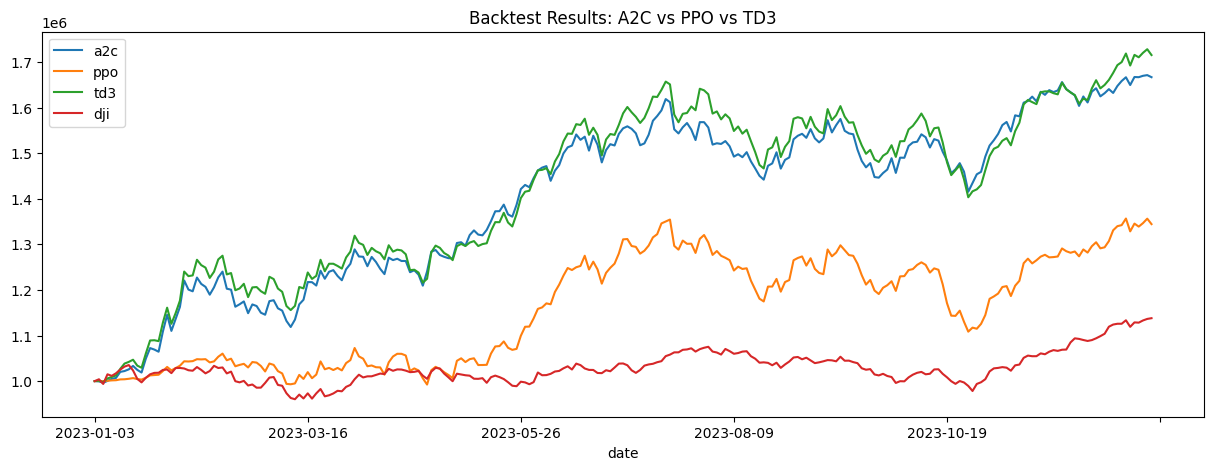

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot(title="Backtest Results: A2C vs PPO vs TD3");


#### Cumulative Return and Sharpe Ratio Metrics


In [ ]:
import numpy as np
import pandas as pd

def backtest_stats(account_value, value_col_name='account_value'):
    daily_return = account_value[value_col_name].pct_change(1).dropna()

    cum_return = account_value[value_col_name].iloc[-1] / account_value[value_col_name].iloc[0] - 1
    annual_volatility = np.std(daily_return) * np.sqrt(252)
    sharpe_ratio = np.mean(daily_return) / np.std(daily_return) * np.sqrt(252)

    cumulative = (1 + daily_return).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    max_drawdown = drawdown.min()

    stats = {
        'Cumulative Return': cum_return,
        'Annual Volatility': annual_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }

    return pd.Series(stats)


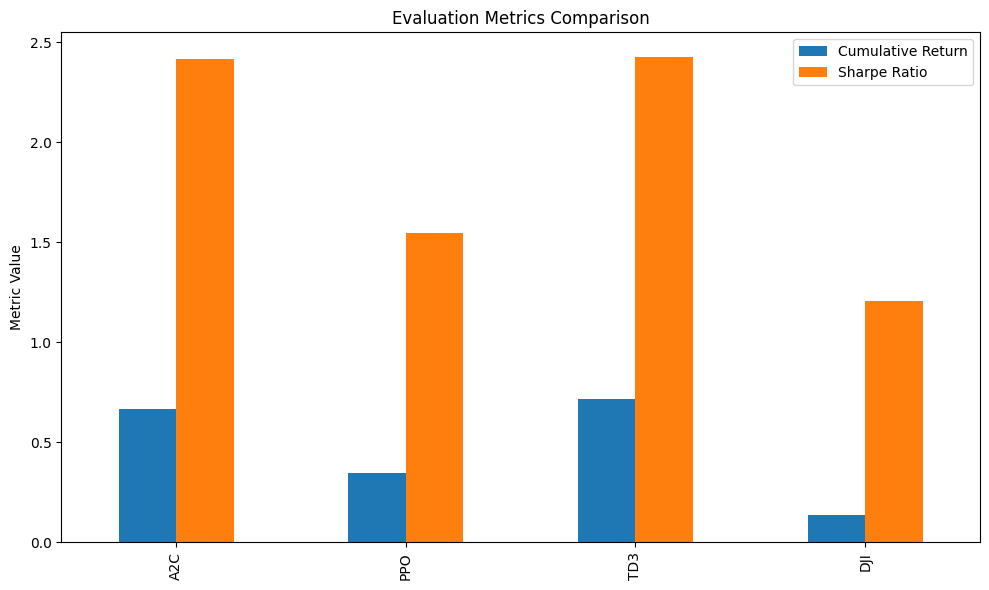

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

stats_a2c = backtest_stats(df_account_value_a2c)
stats_ppo = backtest_stats(df_account_value_ppo)
stats_td3 = backtest_stats(df_account_value_td3)
stats_dji = backtest_stats(df_dji)  #  df_dji with  'account_value' coumn added


metrics_df = pd.DataFrame({
    "A2C": stats_a2c,
    "PPO": stats_ppo,
    "TD3": stats_td3,
    "DJI": stats_dji
})

top_metrics = ["Cumulative Return", "Sharpe Ratio"]
metrics_df_filtered = metrics_df.loc[top_metrics]

# Transpose to have models on x-axis
plot_df = metrics_df_filtered.T

# Plot and store axis object
ax = plot_df.plot(kind='bar', figsize=(10, 6))
plt.title("Evaluation Metrics Comparison")
plt.ylabel("Metric Value")

plt.tight_layout()
plt.show()


In [ ]:
from IPython.display import display

# Round the values for better presentation
display(metrics_df_filtered.T.round(3))

plt.savefig("evaluation_metrics_comparison.png", dpi=300)
metrics_df_filtered.T.to_csv("evaluation_metrics_table.csv")



,Cumulative Return,Sharpe Ratio
A2C,0.667,2.415
PPO,0.344,1.545
TD3,0.715,2.428
DJI,0.138,1.207


<Figure size 1500x500 with 0 Axes>